In [1]:
import sys
lrp_toolbox_path = '/media/sergio/0eb90434-bbe8-4218-a191-4fa0159e1a36/ml_nn/visualize_nets/lrp_toolbox/python' 
sys.path.append(lrp_toolbox_path)
sys.path.append(lrp_toolbox_path + '/modules')

import matplotlib.pyplot as plt
import numpy as np ; na = np.newaxis

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
get_ipython().magic(u'load_ext autoreload')
get_ipython().magic(u'autoreload 2')


/media/sergio/0eb90434-bbe8-4218-a191-4fa0159e1a36/dev/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
import model_io
import data_io
import render

In [3]:
#load a neural network, as well as the MNIST test data and some labels
nn = model_io.read(lrp_toolbox_path+'/../models/MNIST/LeNet-5.nn') # 99.23% prediction accuracy
X = data_io.read(lrp_toolbox_path+'/../data/MNIST/test_images.npy')
Y = data_io.read(lrp_toolbox_path+'/../data/MNIST/test_labels.npy')


# transfer pixel values from [0 255] to [-1 1] to satisfy the expected input / training paradigm of the model
X =  X / 127.5 - 1.


loading pickled model from /media/sergio/0eb90434-bbe8-4218-a191-4fa0159e1a36/ml_nn/visualize_nets/lrp_toolbox/python/../models/MNIST/LeNet-5.nn
loading np-formatted data from /media/sergio/0eb90434-bbe8-4218-a191-4fa0159e1a36/ml_nn/visualize_nets/lrp_toolbox/python/../data/MNIST/test_images.npy
loading np-formatted data from /media/sergio/0eb90434-bbe8-4218-a191-4fa0159e1a36/ml_nn/visualize_nets/lrp_toolbox/python/../data/MNIST/test_labels.npy


In [4]:
#reshape the vector representations in X to match the requirements of the CNN input
X = np.reshape(X,[X.shape[0],28,28,1])
X = np.pad(X,((0,0),(2,2),(2,2),(0,0)), 'constant', constant_values = (-1.,))


# transform numeric class labels to vector indicator for uniformity. assume presence of all classes within the label set
I = Y[:,0].astype(int)
Y = np.zeros([X.shape[0],np.unique(Y).size])
Y[np.arange(Y.shape[0]),I] = 1


In [5]:
print nn
print X.shape, Y.shape

<modules.sequential.Sequential instance at 0x7feebe7c2830>
(10000, 32, 32, 1) (10000, 10)


In [6]:
# printing wheights and Biases shapes of each layer
shapes = [(mod.W.shape) if hasattr(mod, 'W') else '-' for mod in nn.modules]
biases = [(mod.B.shape) if hasattr(mod, 'B') else '-' for mod in nn.modules]
classes = [mod.__class__.__name__ for mod in nn.modules]

[el for el in zip(shapes, biases, classes)]

[((5, 5, 1, 10), (10,), 'Convolution'),
 ('-', '-', 'Rect'),
 ('-', '-', 'SumPool'),
 ((5, 5, 10, 25), (25,), 'Convolution'),
 ('-', '-', 'Rect'),
 ('-', '-', 'SumPool'),
 ((4, 4, 25, 100), (100,), 'Convolution'),
 ('-', '-', 'Rect'),
 ('-', '-', 'SumPool'),
 ((1, 1, 100, 10), (10,), 'Convolution'),
 ('-', '-', 'Flatten')]

In [7]:
i = 0
x = X[i:i+1,...]

#forward pass and prediction
ypred = nn.forward(x)
##############################################
#  X shape across layers in forward pass
##############################################
#forward Convolution , X shape: (1, 32, 32, 1)
#forward Rect , X shape: (1, 28, 28, 10)
#forward SumPool , X shape: (1, 28, 28, 10)
#forward Convolution , X shape: (1, 14, 14, 10)
#forward Rect , X shape: (1, 10, 10, 25)
#forward SumPool , X shape: (1, 10, 10, 25)
#forward Convolution , X shape: (1, 5, 5, 25)
#forward Rect , X shape: (1, 2, 2, 100)
#forward SumPool , X shape: (1, 2, 2, 100)
#forward Convolution , X shape: (1, 1, 1, 100)
#forward Flatten , X shape: (1, 1, 1, 10)
##############################################

In [8]:
print 'True Class:     ', np.argmax(Y[i])
print 'Predicted Class:', np.argmax(ypred),'\n'


True Class:      7
Predicted Class: 7 



In [9]:
#==============================================
# LRP RULES
#==============================================
def conv_lrp(R, conv_layer, type='simple', *args, **kwargs):
    
        
        if type == 'simple':
            '''
            LRP according to Eq(56) in DOI: 10.1371/journal.pone.0130140
            '''

            N,Hout,Wout,NF = R.shape
            hf,wf,df,NF = conv_layer.W.shape
            hstride, wstride = conv_layer.stride

            Rx = np.zeros_like(conv_layer.X,dtype=np.float)

            for i in xrange(Hout):
                for j in xrange(Wout):
                    Z = conv_layer.W[na,...] * conv_layer.X[:, i*hstride:i*hstride+hf , j*wstride:j*wstride+wf , : , na]
                    Zs = Z.sum(axis=(1,2,3),keepdims=True) + conv_layer.B[na,na,na,na,...]
                    Zs += 1e-12*((Zs >= 0)*2 - 1.) # add a weak numerical stabilizer to cushion division by zero
                    Rx[:,i*hstride:i*hstride+hf: , j*wstride:j*wstride+wf: , : ] += ((Z/Zs) * R[:,i:i+1,j:j+1,na,:]).sum(axis=4)
            return Rx
        

def flatten_lrp(R, x_shape):
    '''
    Receives upper layer input relevance R and reshapes it to match the input neurons.
    '''
    # just propagate R further down.
    # makes sure subroutines never get called.
    return np.reshape(R,x_shape)

def non_linearity_lrp(R):
    '''
     just propagate R further down.
    '''
    return R

def sumpool_lrp(R, sumpool_layer, type='simple'):
    
     if type == 'simple':
        '''
        LRP according to Eq(56) in DOI: 10.1371/journal.pone.0130140
        '''
        N,H,W,D = sumpool_layer.X.shape

        hpool,   wpool   = sumpool_layer.pool
        hstride, wstride = sumpool_layer.stride

        #assume the given pooling and stride parameters are carefully chosen.
        Hout = (H - hpool) / hstride + 1
        Wout = (W - wpool) / wstride + 1

        Rx = np.zeros(sumpool_layer.X.shape)
        for i in xrange(Hout):
            for j in xrange(Wout):
                Z = sumpool_layer.X[:, i*hstride:i*hstride+hpool , j*wstride:j*wstride+wpool , : ] #input activations.
                Zs = Z.sum(axis=(1,2),keepdims=True)
                Zs += 1e-12*((Zs >= 0)*2-1) # add a weak numerical stabilizer to cushion an all-zero input

                Rx[:,i*hstride:i*hstride+hpool: , j*wstride:j*wstride+wpool: , : ] += (Z/Zs) * R[:,i:i+1,j:j+1,:]  #distribute relevance propoprtional to input activations per layer

        return Rx


In [10]:
## following backward pass in lrp simple
i = len(nn.modules)-1

flatten_layer = nn.modules[i]
print flatten_layer

R_ = flatten_layer.lrp(ypred)
# for the flatten layer R is simply net output function

print ypred.shape, x.shape
R1 = flatten_lrp(ypred, flatten_layer.inputshape)
print np.linalg.norm(R_ - R1)

# backward pass, next layer
i = i-1

<modules.flatten.Flatten instance at 0x7feebe7c2b48>
(1, 10) (1, 32, 32, 1)
0.0


In [11]:
conv4_layer = nn.modules[i]
print conv4_layer

R2_ = conv4_layer._simple_lrp(R1)

R2 = conv_lrp(R1, conv4_layer)
print np.linalg.norm(R2_ - R2)

# backward pass, next layer
i = i-1

<modules.convolution.Convolution instance at 0x7feebe7c2b00>
0.0


In [12]:
pool_layer3 = nn.modules[i]
print pool_layer3

R3_ = pool_layer3._simple_lrp(R2)

R3 = sumpool_lrp(R2, pool_layer3)
print np.linalg.norm(R3_ - R3)

# backward pass, next layer
i = i-1

<modules.sumpool.SumPool instance at 0x7feebe7c2ab8>
0.0


In [13]:
relu_layer3 = nn.modules[i]
print relu_layer3

R4_ = relu_layer3.lrp(R3)

R4 = non_linearity_lrp(R3)
print np.linalg.norm(R4_ - R4)

# backward pass, next layer
i = i-1

<modules.rect.Rect instance at 0x7feebe7c2a70>
0.0


In [14]:
def show_lrp(R, x):
    #sum over the third (color channel) axis. not necessary here, but for color images it would be.
    R = R.sum(axis=3)
    
    #same for input. create brightness image in [0,1].
    x = ((x+1.)/2.).sum(axis=3)

    #render input and heatmap as rgb images
    digit = render.digit_to_rgb(x, scaling = 3)
    hm = render.hm_to_rgb(R, X = x, scaling = 3, sigma = 2)
    digit_hm = render.save_image([digit,hm],'../heatmap.png')

    #display the image as written to file
    plt.imshow(digit_hm, interpolation = 'none')
    plt.axis('off')
    plt.show()
    
def show_original_lrp(X, i, lpr_type='simple'):
    x = X[i:i+1,...]

    #forward pass and prediction
    ypred = nn.forward(x)
    print 'True Class:     ', np.argmax(Y[i])
    print 'Predicted Class:', np.argmax(ypred),'\n'

    #compute first layer relevance according to prediction
    if lpr_type=='simple':
        R = nn.lrp(ypred)                   #as Eq(56) from DOI: 10.1371/journal.pone.0130140
    #R = nn.lrp(ypred,'epsilon',1.)    #as Eq(58) from DOI: 10.1371/journal.pone.0130140
    #R = nn.lrp(ypred,'alphabeta',2)    #as Eq(60) from DOI: 10.1371/journal.pone.0130140

    #R = nn.lrp(Y[na,i],'epsilon',1.) #compute first layer relevance according to the true class label

    #yselect = 3
    #yselect = (np.arange(Y.shape[1])[na,:] == yselect)*1.
    #R = nn.lrp(yselect,'epsilon',0.1) #compute first layer relvance for an arbitrarily selected class
    show_lrp(R, x)
    
def test_lrp(X, i, lpr_type='simple', show=False, show_original=False):
    
    x = X[i:i+1,...]

    #forward pass and prediction
    ypred = nn.forward(x)
    print 'True Class:     ', np.argmax(Y[i])
    print 'Predicted Class:', np.argmax(ypred),'\n'

    #lrp
    l = len(nn.modules)-1
    for mod in nn.modules[::-1]:
        
        layer = nn.modules[l]
        if(mod.__class__.__name__ == 'Flatten'):
            # must be the last! (first here...)
            #print 'flatten'+str(l)
            R = flatten_lrp(ypred, layer.inputshape)
            
        elif (mod.__class__.__name__ == 'Convolution'):
            #print 'conv'+str(l)
            R = conv_lrp(R, layer)
            
        elif (mod.__class__.__name__ == 'SumPool'):        
            #print 'sumpool'+str(l)
            R = sumpool_lrp(R, layer)
            
        elif (mod.__class__.__name__ == 'Rect' or mod.__class__.__name__ == 'Tanh'): 
            #print 'non-lin'+str(l)
            R = non_linearity_lrp(R)
        
        l=l-1
        
    if show:
        show_lrp(R, x)
        
    if show_original:
        show_original_lrp(X, i, lpr_type)
    return R, x



True Class:      7
Predicted Class: 7 



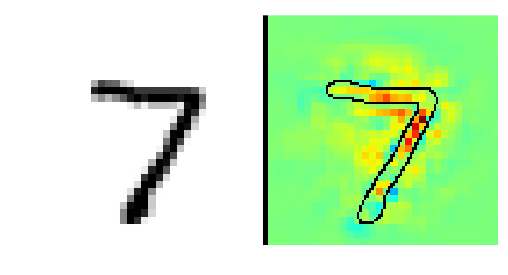

True Class:      7
Predicted Class: 7 



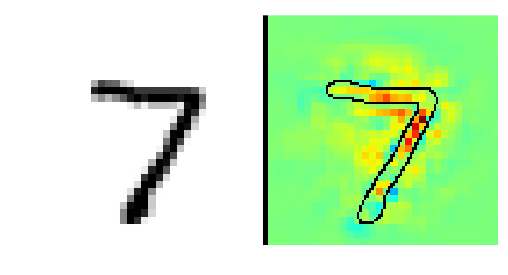

In [16]:
R, x = test_lrp(X, 0, lpr_type='simple', show=True, show_original=True)
